<h1><center>Momentum</center></h1>
* **[Cross-Sectional Momentum. Jegadeesh and Titman (1993)](http://www.bauer.uh.edu/rsusmel/phd/jegadeesh-titman93.pdf)**<br>
  Rank the cross-section of stocks each month based on their return over the past 6 mths
Form decile portfolios each month



* **[Time Series Momentum. Moskowitz, Ooi and Pedersen (2012)](http://quantpedia.com/screener/Details/118)**<br>
  Takes long or short position on an asset by only looking back at its own performance during the formation period, and not based on its relative rank across a cross-section


<h1>Approach and Data</h1>

In this notebook, we aim to replicate the **Time Series Momentum(TSMOM) Moskowitz, Ooi and Pedersen (MOP)** paper. We examined the TSMOM performance by using the same futures contracts and time period (1984 - 2009). After which, we extended the testing period to include Oct 2016. As a form of benchmark, we also examined the buy-and-hold with and without volatility scaling strategy as advocated by **Kim, Tse and Wald** in their **Time Series Momentum and Volatility Scaling** (2016) paper. Data were sourced from Bloomberg.

* 9 developed countries index futures
* 24 commodities futures
* 13 bond futures
* 9 currencies futures
* Jul 1959 - Oct 2016

# Volatility Scaling

In MOP paper, under section 2.4, they discussed using ex ante volatility estimate to scale capital allocation to different futures contract based on each future contracts volatility. The basic idea is very similar to risk bedgeting or risk parity. The following is their explanation:

  *...Since volatility varies dramatically across our assets, we scale the returns by their volatilities in order to make meaningful comparisons across assets. We estimate each instrument's ex ante volatility $\sigma_t$ at each point in time using an extremely simple model: the exponential weighted lagged squared daily returns (i.e., similar to a simple univatiate GARCH model). Specifically, the ex ante annualized variance $\sigma^2_t$ for each instrument is calculated as follows*:
$$\sigma^2_t=261\sum^\infty_{i=0}(1-\delta)\delta^i(r_{t-1-i}-\bar{r}_t)^2$$

  *where the scalar 261 scales the variance to be annual, the weights $(1-\delta)\delta^i$ add up to one, and $\bar{r}_t$ is the exponentially weighted average return computed similarly. The parameter $\delta$ is chosen so that the center of mass of the weights is $\sum^{\infty}_{i=0}(1-\delta)\delta^ii=\delta/(1-\delta)=60$ days. The volatility model is the same for all assets at all times... *

In [1]:
import numpy as np
import pandas as pd
import datetime
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pytz
%matplotlib inline

In [2]:
tolerance = 0.
look_back = 12

# volatity scaling
vol_flag = 1
if vol_flag == 1:   # set flag to 1 for vol targeting
    target_vol = 0.4
else:
    target_vol = 'no target vol'

# 1. Trading Strategy - TSMOM with Volatility Scaling (1984 - 2009)
As per MOP paper covering 1984 - 2009

# 1a. Individual Futures Performance

In [3]:
# res = local_csv("futures.csv")
res = pd.read_csv("../data/futures.csv")
# res = local_csv("futures_incl_2016.csv") # Uncomment this line to include 2016
res['Date'] = pd.to_datetime(res['Date'], format='%Y-%m-%d')
res.set_index('Date', inplace=True)

In [4]:
res.head()

SM  NO        CL  UB        SB  TP  CD  CN        GC  \
Date                                                                     
1984-01-03 -0.046867 NaN -0.007299 NaN -0.038255 NaN NaN NaN -0.016488   
1984-01-04 -0.011366 NaN  0.003614 NaN  0.002395 NaN NaN NaN -0.005494   
1984-01-05  0.013230 NaN -0.007318 NaN -0.011783 NaN NaN NaN -0.005520   
1984-01-06 -0.029521 NaN -0.004134 NaN -0.005356 NaN NaN NaN -0.020646   
1984-01-09 -0.022181 NaN  0.009487 NaN -0.024679 NaN NaN NaN -0.006463   

                  TY    ...           CC        S   SE  NV  HO  GX  JY  FV  \
Date                    ...                                                  
1984-01-03 -0.002853    ...    -0.017268 -0.036257 NaN NaN NaN NaN NaN NaN   
1984-01-04  0.004430    ...    -0.036874 -0.013712 NaN NaN NaN NaN NaN NaN   
1984-01-05 -0.000253    ...     0.019696  0.017140 NaN NaN NaN NaN NaN NaN   
1984-01-06  0.002338    ...    -0.043456 -0.031650 NaN NaN NaN NaN NaN NaN   
1984-01-09 -0.001287    ...    -0.034017 -0.015249 NaN NaN NaN NaN NaN NaN   

            JB        LC  
Date                      
1984-01-03 NaN -0.013526  
1984-01-04 NaN  0.002736  
1984-01-05 NaN  0.022081  
1984-01-06 NaN -0.010451  
1984-01-09 NaN -0.004293  

[5 rows x 55 columns]

In [5]:
std_index = res.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', \
                                    'Skew', 'Kurt', 'Sharpe Ratio'])

In [6]:
for oo in res.columns:
    returns = res[oo]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [oo, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    ret_m_index.ix[0][oo] = 1

    mth_index = pd.concat([mth_index, ret_m_index[oo]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = oo + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[oo].pct_change().mean()*252
    tmp_std = ret_index[oo].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[oo].pct_change().skew()
    tmp_kurt = ret_index[oo].pct_change().kurt()
    sr = tmp_mean / tmp_std

    dict = {'Asset': oo,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[oo] = pd.Series(dict)    

In [7]:
summary_stats = summary_stats.transpose()

In [8]:
summary_stats.head()

Asset       Start    Mean     Std    Skew     Kurt Sharpe Ratio
SM    SM  1984-01-03  0.0533  0.2439  -0.031   2.5715       0.2186
NO    NO  2002-05-20  0.0472  0.1346 -0.1743   2.9403       0.3508
CL    CL  1984-01-03  0.1346  0.3759 -0.3765  10.9173        0.358
UB    UB  1998-10-06  0.0038  0.0997 -0.1955   2.0124       0.0382
SB    SB  1984-01-03  0.0181  0.3685 -0.0212   4.0372       0.0492

In [14]:
# summary_stats = summary_stats.transpose()

In [15]:
summary_stats.head()

Asset       Start    Mean     Std    Skew     Kurt Sharpe Ratio
SM    SM  1984-01-03  0.0533  0.2439  -0.031   2.5715       0.2186
NO    NO  2002-05-20  0.0472  0.1346 -0.1743   2.9403       0.3508
CL    CL  1984-01-03  0.1346  0.3759 -0.3765  10.9173        0.358
UB    UB  1998-10-06  0.0038  0.0997 -0.1955   2.0124       0.0382
SB    SB  1984-01-03  0.0181  0.3685 -0.0212   4.0372       0.0492

In [16]:
# futures_list = local_csv("futures_list.csv")
futures_list = pd.read_csv("../data/futures_list.csv")

In [17]:
futures_list.head()

Asset              FUTURES ASSET_CLASS
0    CN  CANADA 10-YEAR BOND        BOND
1    DU          EURO SCHATZ        BOND
2    FV       US 5-YEAR NOTE        BOND
3    G             LONG GILT        BOND
4    JB   JAPAN 10-YEAR BOND        BOND

In [18]:
all = summary_stats.reset_index().merge(futures_list)

In [19]:
all.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del all['Asset'], all['index']

### Individual Futures Contracts Performance
These are annualized performance.

In [20]:
all.set_index(['ASSET_CLASS', 'FUTURES']).style.set_properties(**{'text-align': 'right'})

# 1b. Trading Strategy - TSMOM with Volatility Scaling (1984 - 2009)


Perform a Time Series Momentum strategy on each price series.
* Long those with positive momentum
* Short those with negative momentum

In [21]:
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [22]:
for oo in mth_index:
    df = pd.concat([mth_index[oo], mth_index_vol[oo+"_Vol"]], axis=1)
    df['returns'] = df[oo].pct_change(look_back)
    
    df['pnl'] = 0.
    df['leverage'] = 0.
    try:
        for k, v in enumerate(df['returns']):
            if k <= look_back:
                # skip the first 12 observations
                continue
            if df['returns'].iloc[k-1] < tolerance:
                # negative returns, sell and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k - 1] / df[oo].iloc[k] - 1)                   
                    df['leverage'].iloc[k] = 1.
            elif df['returns'].iloc[k-1] > tolerance:
                # positive returns, buy and hold for 1 mth, then close position
                if vol_flag == 1:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - 1]
                    df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - 1]
                else:
                    df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - 1] - 1) 
                    df['leverage'].iloc[k] = 1.
    except: pass    
    # convert to cummulative index
    pnl = pd.concat([pnl, df['pnl']], axis=1)
    leverage = pd.concat([leverage, df['leverage']], axis=1)
    
    ret_index = (1 + df['pnl'][13:]).cumprod()
    ret_index[0] = 1
    strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1) 

In [23]:
pnl.columns = res.columns
leverage.columns = leverage.columns
strategy_cumm_rtns.columns = res.columns
df = pnl
df['port_avg'] = df.mean(skipna = 1, axis=1)
Strategy = df['port_avg'].copy()
Strategy.name = "TSMOM with Vol"
dataport_index = (1 + df['port_avg']).cumprod()

In [24]:
print "Annualized Sharpe Ratio = ", pf.empyrical.sharpe_ratio(df['port_avg'], period='monthly')
print "Annualized Mean Returns = ", pf.empyrical.annual_return(df['port_avg'], period='monthly')
print "Annualized Standard Deviations = ", pf.empyrical.annual_volatility(df['port_avg'], period='monthly')

Annualized Sharpe Ratio =  1.55942862102
Annualized Mean Returns =  0.158205253154
Annualized Standard Deviations =  0.0977748556597


In [25]:
print "Max Drawdown = ", pf.empyrical.max_drawdown(df['port_avg'])
print "Calmar ratio = ", pf.empyrical.calmar_ratio(df['port_avg'], period='monthly')

Max Drawdown =  -0.140726202907
Calmar ratio =  1.12420608164


# Other Strategies

The performance of Time Series Momentum with volatility scaling (MOP strategy) up to and including Sep 2016 (not shown) is:

* Annualized Sharpe Ratio =  1.32240147363
* Annualized Mean Returns =  0.144648073277
* Annualized Standard Deviations =  0.107003671777
* Max Drawdown =  -0.140726203354
* Calmar ratio =  1.02786879649

The performance of Time Series Momentum without volatility scaling is:

* Annualized Sharpe Ratio =  1.18250924383
* Annualized Mean Returns =  0.0593476792819
* Annualized Standard Deviations =  0.0499137056686
* Max Drawdown =  -0.125187506104
* Calmar ratio =  0.474070305648

Entire data start date: 1984-01-30
Entire data end date: 2009-12-30


Backtest Months: 14


Performance statistics   Backtest
cum_returns_final           44.54
annual_return               20.85
annual_volatility            0.45
sharpe_ratio                 7.15
calmar_ratio               148.18
stability_of_timeseries      0.96
max_drawdown                -0.14
omega_ratio                  3.37
sortino_ratio               15.12
skew                         0.14
kurtosis                     0.77
tail_ratio                   1.75
common_sense_ratio          38.30
information_ratio            0.47
alpha                        4.00
beta                        -0.07

Worst Drawdown Periods net drawdown in %  peak date valley date recovery date  \
0                                  14.07 2003-05-29  2003-08-28    2003-12-30   
1                                  13.54 2009-02-26  2009-07-30           NaT   
2                                   9.17 2008-06-29  2008-09-29    2008-10-30   
3                                   9.13 1995-03-30  1995-08-30    1996-04-29   
4                                   8.03 1993-12-30  1994-03-30    1994-10-30   

Worst Drawdown Periods duration  
0                           153  
1                           NaN  
2                            89  
3                           283  
4                           217



[-0.05 -0.05]


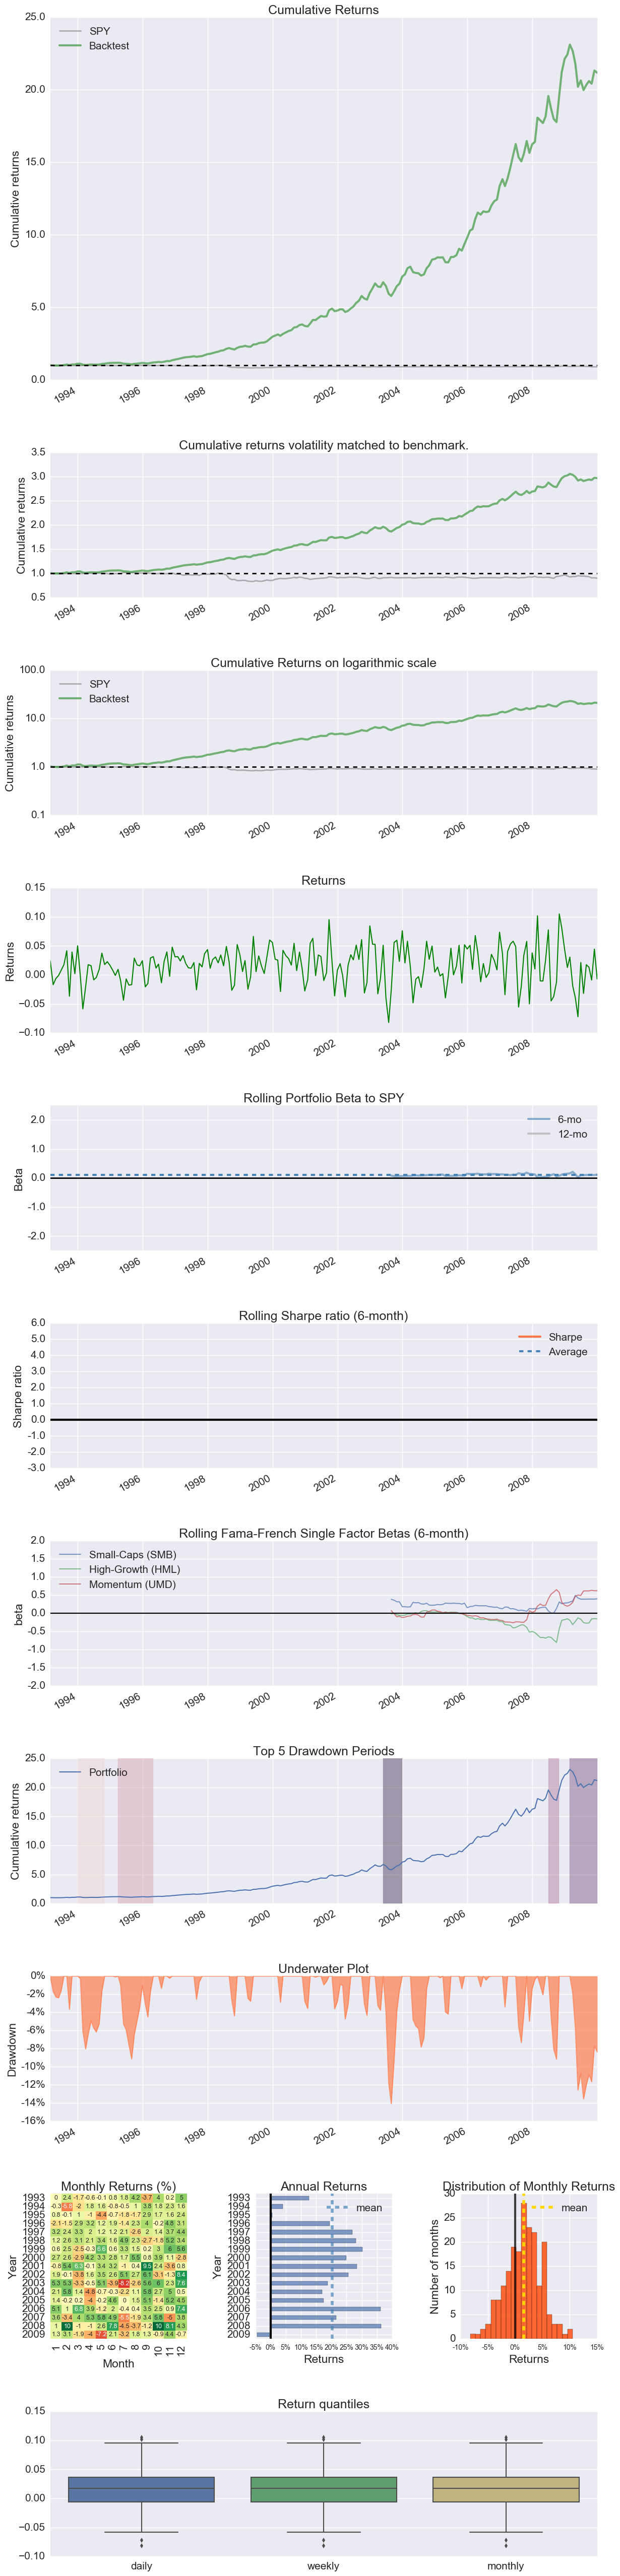

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events                mean    min    max
Dotcom                      2.44% -2.87%  5.45%
Lehmann                    -2.47% -3.74% -1.21%
9/11                        9.52%  9.52%  9.52%
US Housing                  5.28%  5.28%  5.28%
Aug07                      -1.90% -1.90% -1.90%
Mar08                      -1.04% -1.04% -1.04%
Sept08                     -1.21% -1.21% -1.21%
2009Q1                      2.17%  1.28%  3.07%
2009Q2                     -4.35% -7.21% -1.88%
Low Volatility Bull Market  2.04% -5.54%  7.36%
GFC Crash                   2.07% -4.99% 10.51%
Recovery                   -0.70% -7.21%  4.44%

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=730756.0, right=730756.0
  'left=%s, right=%s') % (left, right))
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=731246.0, right=731246.0
  'left=%s, right=%s') % (left, right))
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732919.0, right=732919.0
  'left=%s, right=%s') % (left, right))
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical 

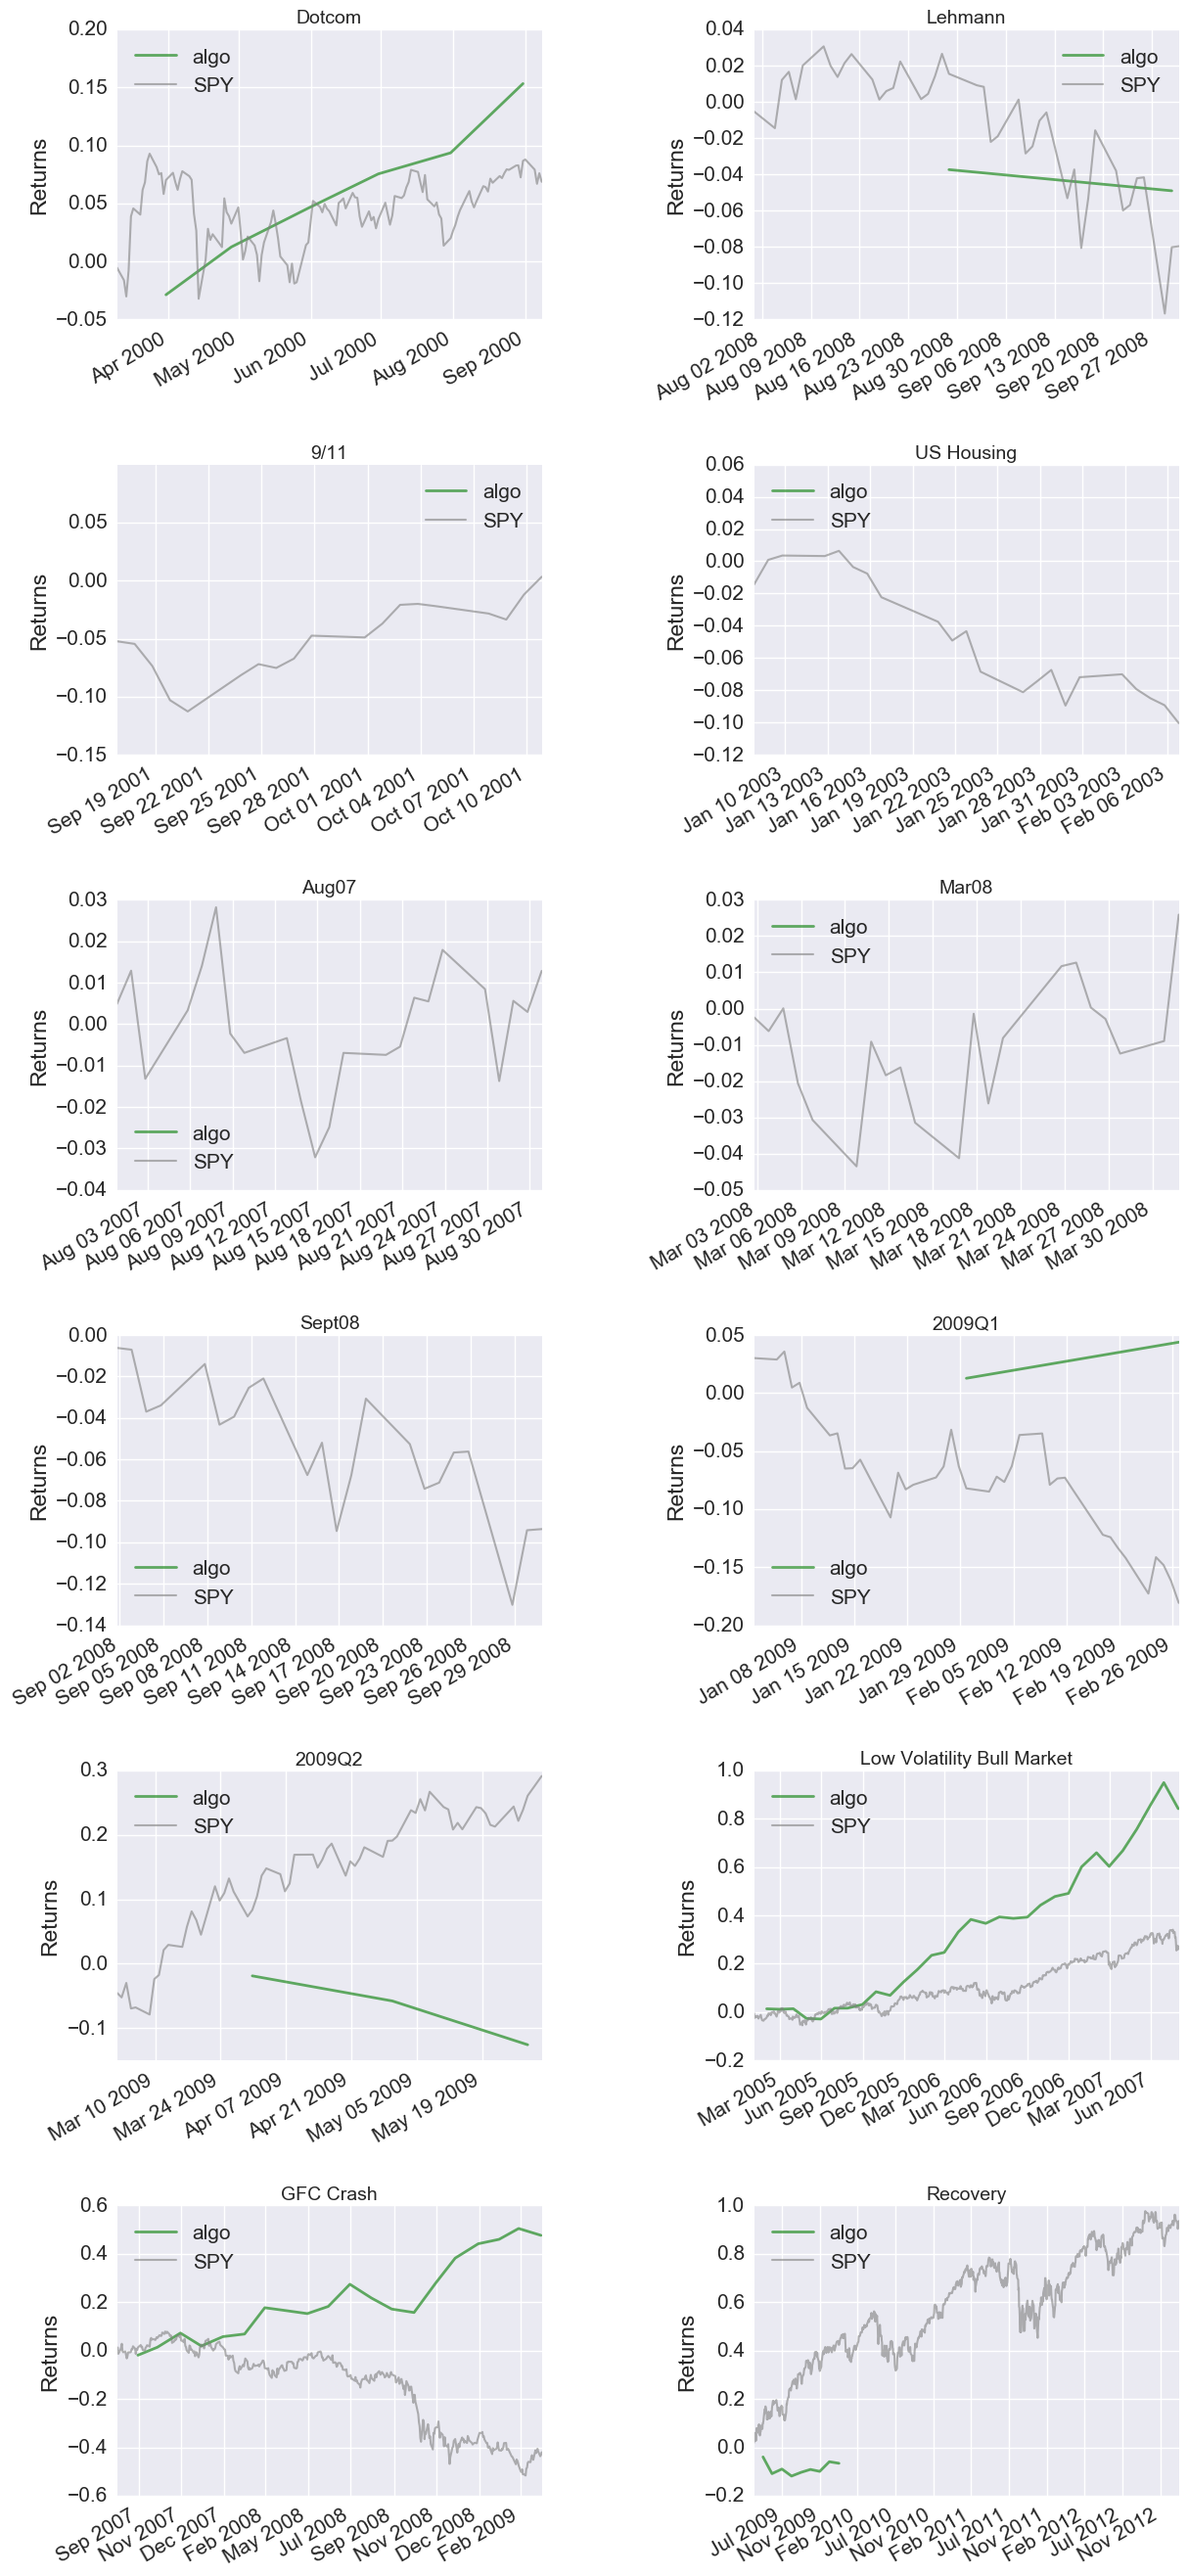

In [26]:
eastern = pytz.timezone('US/Eastern')
df['port_avg'].index = df['port_avg'].index.tz_localize(pytz.utc).tz_convert(eastern)
pf.create_full_tear_sheet(df['port_avg'])

5